In [23]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
import pickle

LOG_FREQ = 10
method_list = ['random_data', 'random_data_informed', 'ts_informed']
DATASET_LIST = ['cifar100', 'svhn', '20newsgroup', 'dbpedia'] 
output_dir = pathlib.Path("../output/confusion_matrix")

metric = 'confusion_matrix' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 1
RUNS = 1000
superclass = False #todo: superclass=true
cost_matrix = None
topk = 1
    

In [26]:
dataset_name = 'dbpedia'

dbpedia False


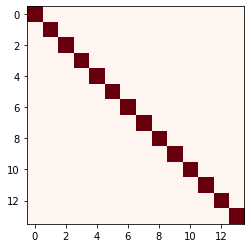

In [43]:
# load results and compute ground truth
ground_truth = {}
weight_k = {}
l2_error = {}
logp = {} # log likelihood of each estimated confusion matrix under dirichlet distribution

# load data
if len(dataset_name) > len('superclass') and dataset_name[-len('superclass'):] == 'superclass':
    superclass = True
else:
    superclass = False

print(dataset_name, superclass)
experiment_name = '%s_top%d_pseudocount%d' % (dataset_name, topk, pseudocount)
if superclass:
    dataset = SuperclassDataset.load_from_text(dataset_name.split('_')[0], CIFAR100_SUPERCLASS_LOOKUP)
    # no need to group (grouped by superclass automatically)
else:
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)

# ground truth
weight_k = dataset.weight_k
confusion_probs = dataset.confusion_probs()
confusion_probs = confusion_probs + np.ones(confusion_probs.shape) * 1e-6
confusion_probs = confusion_probs / confusion_probs.sum(axis=1)
ground_truth['confusion_matrix'] = confusion_probs
ground_truth['confusion_matrix'] = \
        np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % ('random_data_informed', 2)), 'rb'))[1000-1]

plt.imshow(np.log(ground_truth['confusion_matrix']+ 1e-10).T, vmin=-10, vmax=0, cmap='Reds')

In [38]:
np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % ('ts_uniform', 0)), 'rb')).shape

(7000, 14, 14)

In [44]:
dataset.accuracy

0.9923714285714286

In [ ]:
 # initalize l2 error
for method_name in method_list:
    l2_error[method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
    logp[method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
    # load results
for r in tqdm(range(RUNS)):
    for method_name in method_list:
        mpe_log = np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % (method_name, r)), 'rb'))            
        l2_eval = mpe_log - ground_truth['confusion_matrix']
        l2_eval = l2_eval ** 2
        l2_eval = np.sum(l2_eval,axis=2)
        l2_error[method_name][r] = np.array([(l2_eval[i] * weight_k).sum()
                                                           for i in range(dataset.__len__() // LOG_FREQ)])
# baseline
mpe_diag = np.identity(dataset.num_groups)
l2_eval = mpe_diag - ground_truth['confusion_matrix']
l2_eval = l2_eval ** 2
l2_eval = np.sum(l2_eval,axis=1)
l2_error['diagonal'] = np.array((l2_eval * weight_k).sum())

mpe_ones = np.ones((dataset.num_groups,dataset.num_groups))
mpe_ones /= dataset.num_groups
l2_eval = mpe_ones - ground_truth['confusion_matrix']
l2_eval = l2_eval ** 2
l2_eval = np.sum(l2_eval,axis=1)
l2_error['ones'] = np.array((l2_eval * weight_k).sum())

mpe_scores = confusion_probs
l2_eval = mpe_scores - ground_truth['confusion_matrix']
l2_eval = l2_eval ** 2
l2_eval = np.sum(l2_eval,axis=1)
l2_error['scores'] = np.array((l2_eval * weight_k).sum())


pickle.dump(ground_truth, open(output_dir / experiment_name / "ground_truth.pkl", "wb"))  
pickle.dump(l2_error, open(output_dir / experiment_name / "l2_error.pkl", "wb")) 
pickle.dump(logp, open(output_dir / experiment_name / "logp.pkl", "wb")) 
pickle.dump(weight_k, open(output_dir / experiment_name / "weight_k.pkl", "wb")) 